# Exploratory Data Analysis

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Configuration & Mappings

In [38]:
# Column Renaming Dictionary
COLUMN_MAP = {
    'SEQN': 'Respondent_ID',
    'RIAGENDR': 'Gender',
    'RIDAGEYR': 'Age',
    'RIDRETH3': 'Race_Ethnicity',
    'DMDHHSIZ': 'Household_Size',
    'INDFMPIR': 'Poverty_Income_Ratio',
    'SLD012': 'Sleep_Hours_Weekdays',
    'SLD013': 'Sleep_Hours_Weekends',
    'PAD790Q': 'Frequency_Moderate_LTPA',
    'PAD790U': 'Moderate_LTPA_Unit',
    'PAD800': 'Mins_Moderate_Activity',
    'PAD810Q': 'Frequency_Vigorous_LTPA',
    'PAD810U': 'Vigorous_LTPA_Unit',
    'PAD820': 'Mins_Vigorous_Activity',
    'DPQ050': 'Poor_Appetite_Overeating',
    'DPQ020': 'Feeling_Depressed',
    'ALQ111': 'Ever_Drank_Alcohol',
    'OCD150': 'Work_Status'
}

# Value Recoding Dictionaries (Based on NHANES Codebooks)
VALUE_MAPS = {
    'Gender': {
        1.0: 'Male', 
        2.0: 'Female'
    },
    'Race_Ethnicity': {
        1.0: 'Mexican American',
        2.0: 'Other Hispanic',
        3.0: 'Non-Hispanic White',
        4.0: 'Non-Hispanic Black',
        6.0: 'Non-Hispanic Asian',
        7.0: 'Other/Multi-Racial'
    },
    'Ever_Drank_Alcohol': {
        1.0: 'Yes', 
        2.0: 'No', 
        7.0: 'Refused', 
        9.0: 'Don\'t Know'
    },
    'Work_Status': {
        1.0: 'Working at job/business',
        2.0: 'With job, not at work',
        3.0: 'Looking for work',
        4.0: 'Not working'
    },
    # Depression screener is usually 0-3 scale
    'Feeling_Depressed': {
        0.0: 'Not at all',
        1.0: 'Several days',
        2.0: 'More than half the days',
        3.0: 'Nearly every day'
    },
    'Poor_Appetite_Overeating': {
        0.0: 'Not at all',
        1.0: 'Several days',
        2.0: 'More than half the days',
        3.0: 'Nearly every day'
    }
}

# Data Loading & Cleaning

In [39]:
df = pd.read_csv('data/nhanes_2021_2023_adults_combined.csv')
df = df.rename(columns=COLUMN_MAP)
    
# Fix Floating Point Errors (The e-79 issue)
# SAS transport files often create tiny numbers instead of true zeros.
# We round very small numbers to 0.
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    df[col] = df[col].apply(lambda x: 0.0 if abs(x) < 1e-9 else x)

# Recode Values
for col, mapping in VALUE_MAPS.items():
    if col in df.columns:
        df[col] = df[col].map(mapping)

# Dealing With Missingess

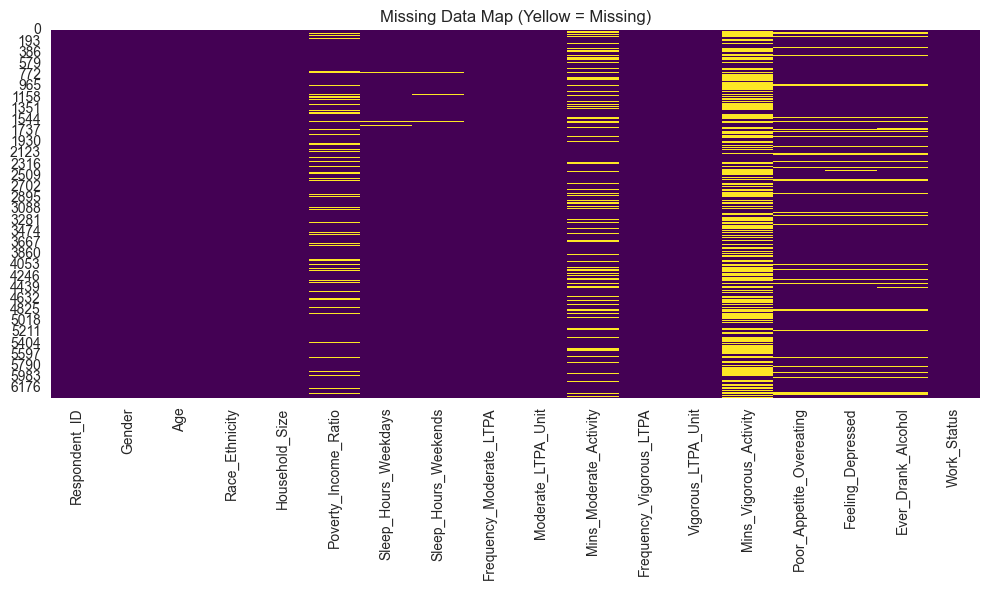

In [40]:
sns.set_style("whitegrid")

# Missing Values Map
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Map (Yellow = Missing)')
plt.tight_layout()
plt.show()

### Missingness in Activity - Setting Missing to 0

In [41]:
cols = [
    'Frequency_Moderate_LTPA',
    'Mins_Moderate_Activity',
    'Frequency_Vigorous_LTPA',
    'Mins_Vigorous_Activity'
]

df[cols] = df[cols].replace(
    {7777: 0, 9999: 0, '7777': 0, '9999': 0, '.': 0}
)

df[cols] = df[cols].fillna(0)

### Missingness in Activity - Imputing from conditional distribution on Race Ethnicity and Household Size

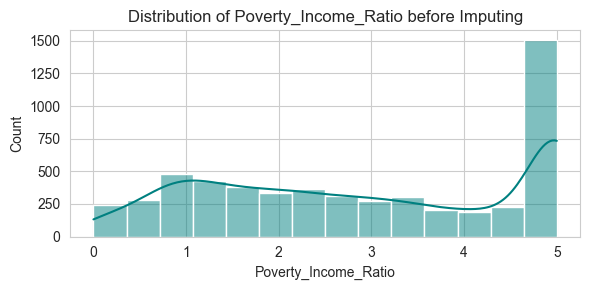

In [42]:
num_cols = ['Poverty_Income_Ratio']

for col in num_cols:
    if col in df.columns:
        plt.figure(figsize=(6, 3))
        ax = sns.histplot(df[col].dropna(), kde=True, color='teal')
        ax.set_title(f'Distribution of {col} before Imputing')
        plt.tight_layout()
        plt.show()

In [43]:
col = 'Poverty_Income_Ratio'
group_cols = ['Race_Ethnicity', 'Household_Size']

overall_non_missing = df[col].dropna().values

rng = np.random.default_rng(seed=36)

def impute_from_group_dist(g):
    mask = g[col].isna()
    if not mask.any():
        return g
    
    non_missing = g[col].dropna().values
    
    if non_missing.size == 0:
        draw_from = overall_non_missing
    else:
        draw_from = non_missing
    
    sampled = rng.choice(draw_from, size=mask.sum(), replace=True)
    g.loc[mask, col] = sampled
    return g

df['Poverty_Income_Ratio_imputed'] = df['Poverty_Income_Ratio']
df = (
    df
    .groupby(group_cols, group_keys=False)
    .apply(impute_from_group_dist)
)

C:\Users\jenny\AppData\Local\Temp\ipykernel_36796\2346264124.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(impute_from_group_dist)


In [44]:
df = df.drop('Poverty_Income_Ratio_imputed', axis=1)

### Missingness in Sleep Hours

We drop all this rows since 

1) we are predicting hours slept
2) it accounts for 0.02% if the dataset

In [45]:
df = df.dropna(subset=['Sleep_Hours_Weekdays', 'Sleep_Hours_Weekends'])

### Missingness in Poor Alcohol and Feeling Depressed

We decided to impute these with the median, which were 'Not at all', normal baselines for humans.

In [46]:
cols = [
    'Poor_Appetite_Overeating',
    'Feeling_Depressed'
]

df[cols] = df[cols].fillna('Not at all')

### Missingness in Alcohol

In retrospect, we decided to drop the ever_drank_alcohol feature from model training. First, the variable is likely subject to systematic underreporting, especially among 18-year-olds who may be reluctant to disclose alcohol use, introducing bias rather than signal. Second, the column contains 843 missing values, which is a sizable amount of missingness relative to the sample and would require nontrivial imputation assumptions. Given these concerns about both data quality and completeness, we chose not to include this feature in future models.

# Feature Engineering

### 1. Average Daily Hours Active

### Calculation Methodology: Average Exercise Per Day

The **Avg_Exercise_Per_Day** was derived from six original columns representing two distinct categories of activity:

1.  **Moderate Activity:** (`Frequency_Moderate_LTPA`, `Moderate_LTPA_Unit`, `Mins_Moderate_Activity`)
2.  **Vigorous Activity:** (`Frequency_Vigorous_LTPA`, `Vigorous_LTPA_Unit`, `Mins_Vigorous_Activity`)

**The Process:**
*   **Standardization:** Because respondents reported frequency in different units (Daily, Weekly, Monthly, Yearly), we used the `_Unit` columns to calculate a daily multiplication factor (e.g., Weekly = $1/7$).
*   **Calculation:** We calculated the daily minutes for each category separately using the formula: `Frequency * Daily Factor * Duration`.
*   **Aggregation:** The final metric is the sum of the calculated **Daily Moderate Minutes** and **Daily Vigorous Minutes**.

In [47]:
def get_daily_minutes(row, freq_col, unit_col, min_col):
    """
    Helper function to normalize activity to minutes per day.
    """
    freq = row[freq_col]
    unit = str(row[unit_col])
    mins = row[min_col]

    # Treat missing values as 0
    if pd.isna(freq) or pd.isna(mins):
        return 0.0

    # Standardization
    if 'D' in unit:
        factor = 1.0          # Daily
    elif 'W' in unit:
        factor = 1.0 / 7.0    # Weekly
    elif 'M' in unit:
        factor = 1.0 / 30.0   # Monthly
    elif 'Y' in unit:
        factor = 1.0 / 365.0  # Yearly
    else:
        factor = 0.0

    return freq * factor * mins

# Calculate Moderate and Vigorous daily averages internally
moderate_daily = df.apply(
    lambda x: get_daily_minutes(x, 'Frequency_Moderate_LTPA', 'Moderate_LTPA_Unit', 'Mins_Moderate_Activity'), 
    axis=1
)

vigorous_daily = df.apply(
    lambda x: get_daily_minutes(x, 'Frequency_Vigorous_LTPA', 'Vigorous_LTPA_Unit', 'Mins_Vigorous_Activity'), 
    axis=1
)

# Create the final averaged column
df['Avg_Exercise_Per_Day'] = moderate_daily + vigorous_daily

# Define the unneeded columns to remove
columns_to_remove = [
    'Frequency_Moderate_LTPA', 'Moderate_LTPA_Unit', 'Mins_Moderate_Activity',
    'Frequency_Vigorous_LTPA', 'Vigorous_LTPA_Unit', 'Mins_Vigorous_Activity'
]

# Drop columns
df.drop(columns=columns_to_remove, inplace=True)

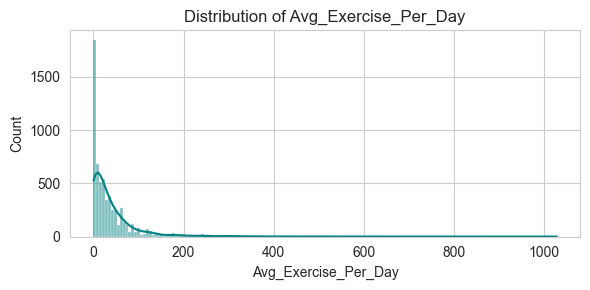

In [48]:
num_cols = ['Avg_Exercise_Per_Day']

for col in num_cols:
    if col in df.columns:
        plt.figure(figsize=(6, 3))
        ax = sns.histplot(df[col].dropna(), kde=True, color='teal')
        ax.set_title(f'Distribution of {col}')
        plt.tight_layout()
        plt.show()

### 2. Average Daily Hours Slept

We will use a 7-day weighted average:
$$
\text{Avg\_Sleep} = \frac{5 \cdot \text{Sleep\_Hours\_Weekdays} + 2 \cdot \text{Sleep\_Hours\_Weekends}}{7}
$$


In [49]:
df['Avg_Sleep'] = (
    5 * df['Sleep_Hours_Weekdays'] +
    2 * df['Sleep_Hours_Weekends']
) / 7

# Exploratory Data Analysis

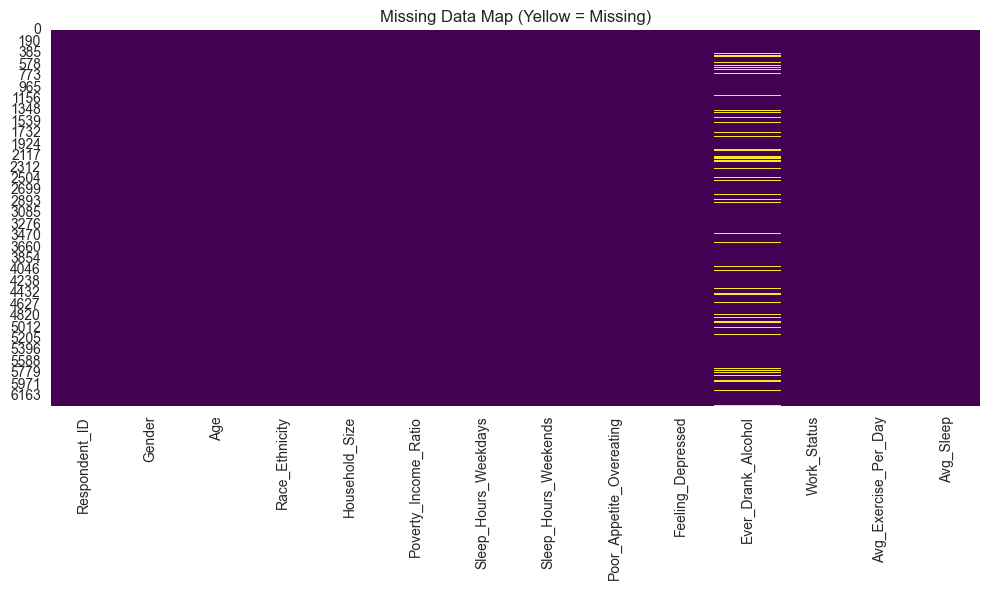

In [50]:
# Missing Values Map
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Map (Yellow = Missing)')
plt.tight_layout()
plt.show()

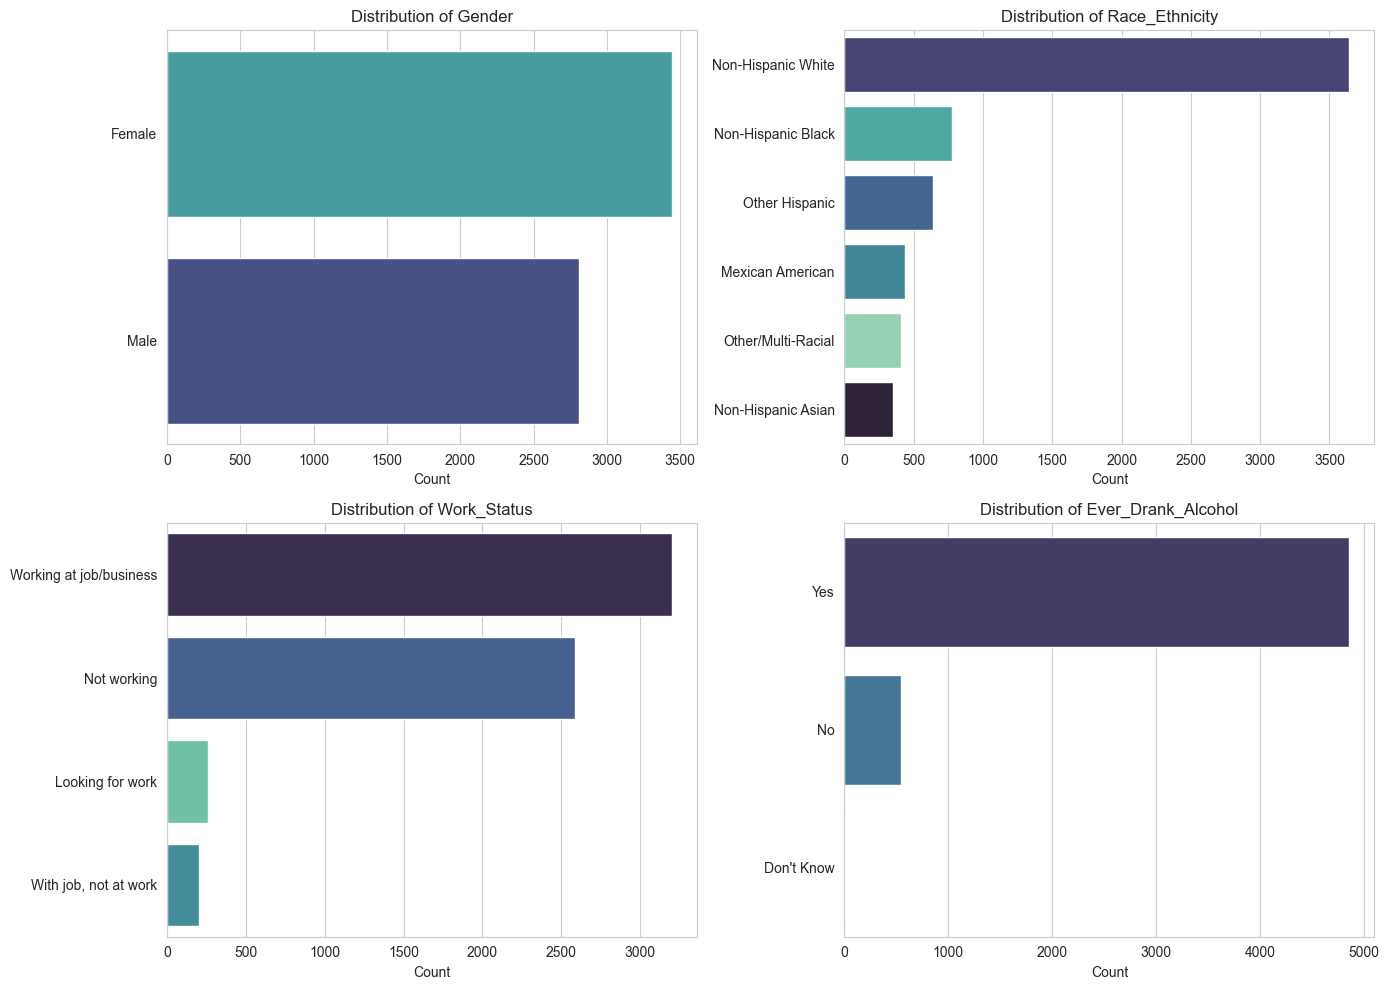

In [51]:
cat_cols = ['Gender', 'Race_Ethnicity', 'Work_Status', 'Ever_Drank_Alcohol']
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    if col in df.columns:
        sns.countplot(
            data=df,
            y=col,
            hue=col,                     
            ax=axes[i],
            palette="mako",
            order=df[col].value_counts().index
        )
        leg = axes[i].get_legend()
        if leg is not None:
            leg.remove()

        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel('Count')
        axes[i].set_ylabel('')

plt.tight_layout()
plt.show()


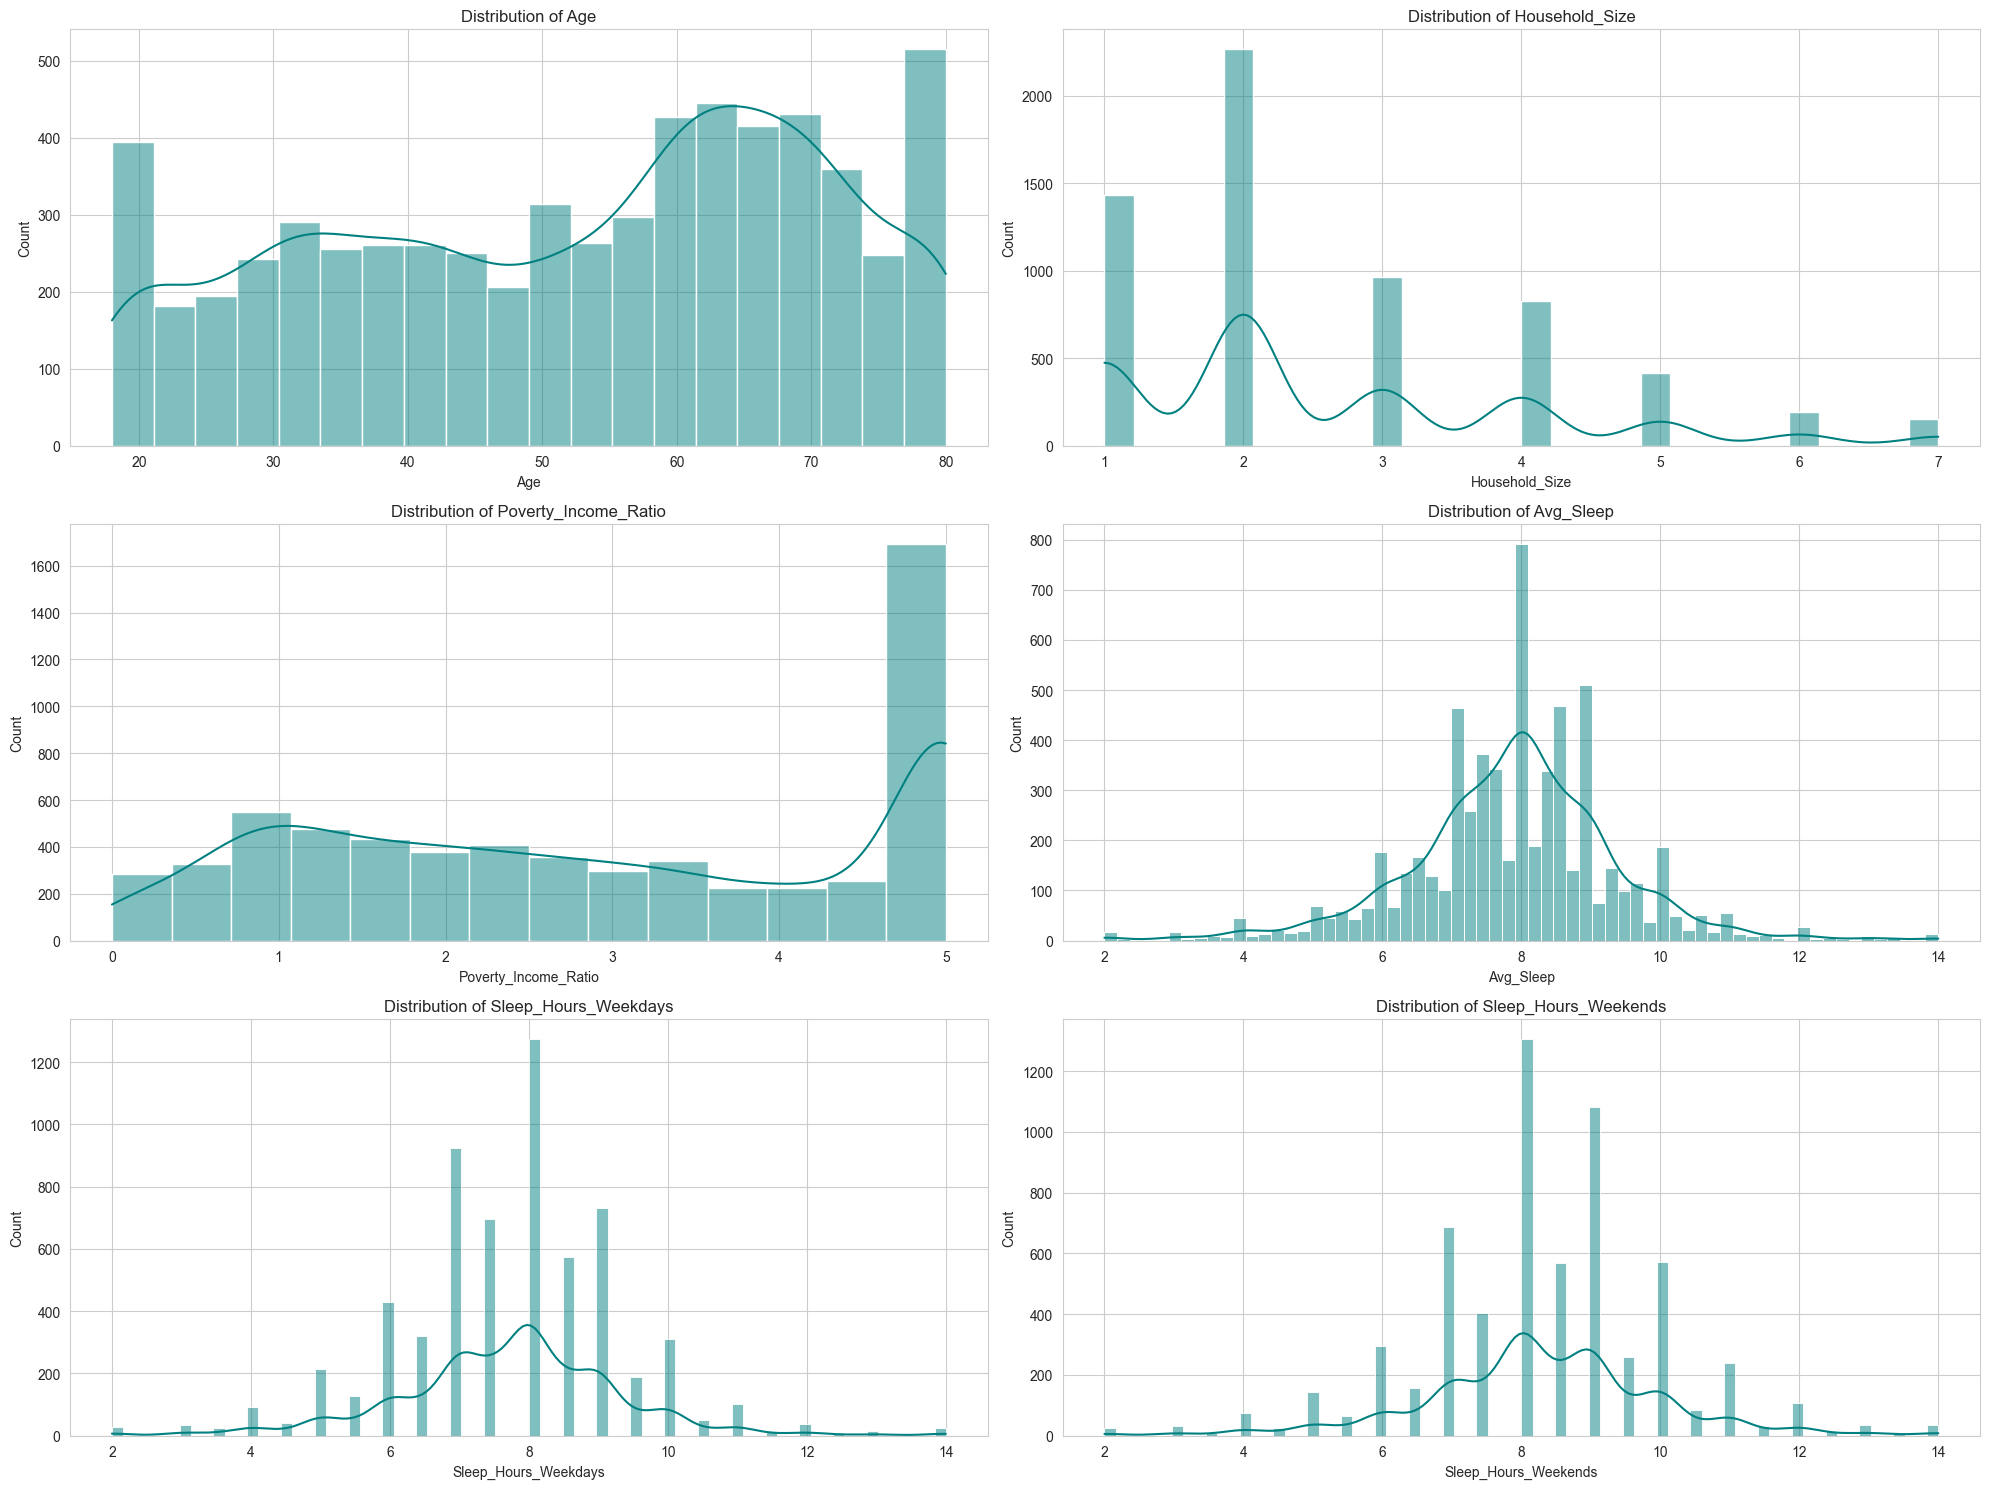

In [52]:

# C. Numerical Distributions
num_cols = ['Age', 'Household_Size', 'Poverty_Income_Ratio', 'Avg_Sleep', 'Sleep_Hours_Weekdays','Sleep_Hours_Weekends']
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    if col in df.columns:
        sns.histplot(df[col].dropna(), kde=True, ax=axes[i], color='teal')
        axes[i].set_title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

In [53]:
# D. Physical Activity Comparison (Boxplots)
pa_cols = ['Mins_Moderate_Activity', 'Mins_Vigorous_Activity']
if any(c in df.columns for c in pa_cols):
    plt.figure(figsize=(10, 6))

    pa_melt = df.melt(
        value_vars=[c for c in pa_cols if c in df.columns],
        var_name='Activity_Type',
        value_name='Minutes'
    )

    ax = sns.boxplot(
        x='Activity_Type',
        y='Minutes',
        data=pa_melt,
        hue='Activity_Type',  
        palette='Set2'
    )

    if ax.legend_ is not None:
        ax.legend_.remove()

    plt.title('Distribution of Physical Activity Minutes')
    plt.tight_layout()
    plt.show()


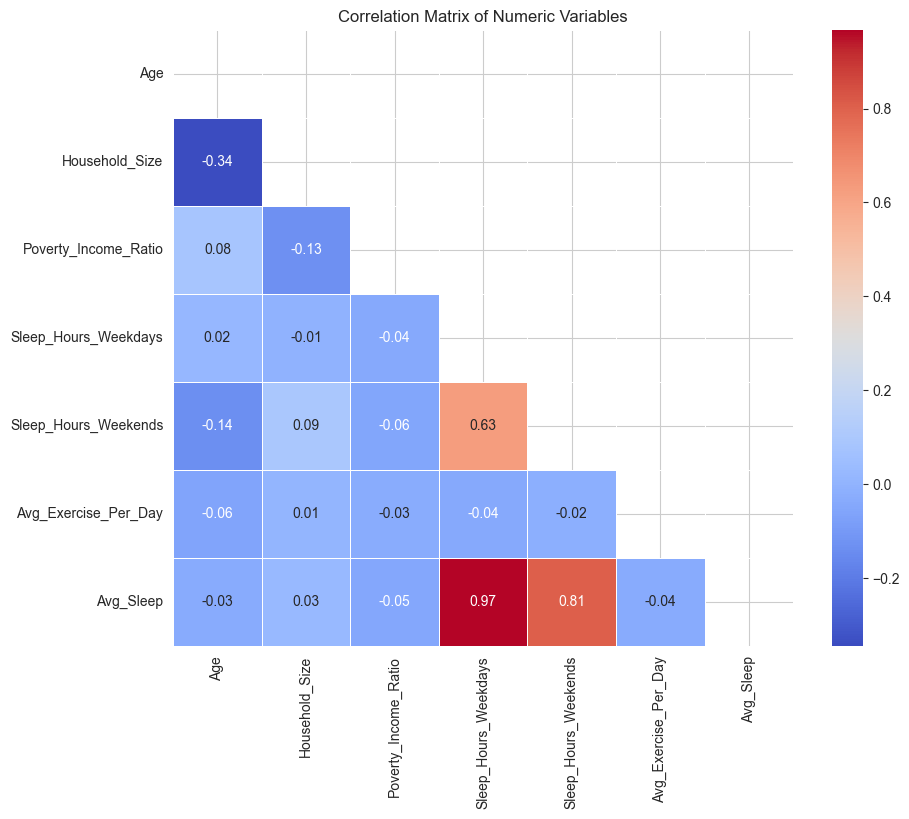

In [54]:
# E. Correlation Heatmap (Numeric Only)
plt.figure(figsize=(10, 8))
numeric_df = df.select_dtypes(include=[np.number]).drop(columns=['Respondent_ID'], errors='ignore')
corr = numeric_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numeric Variables')
plt.show()

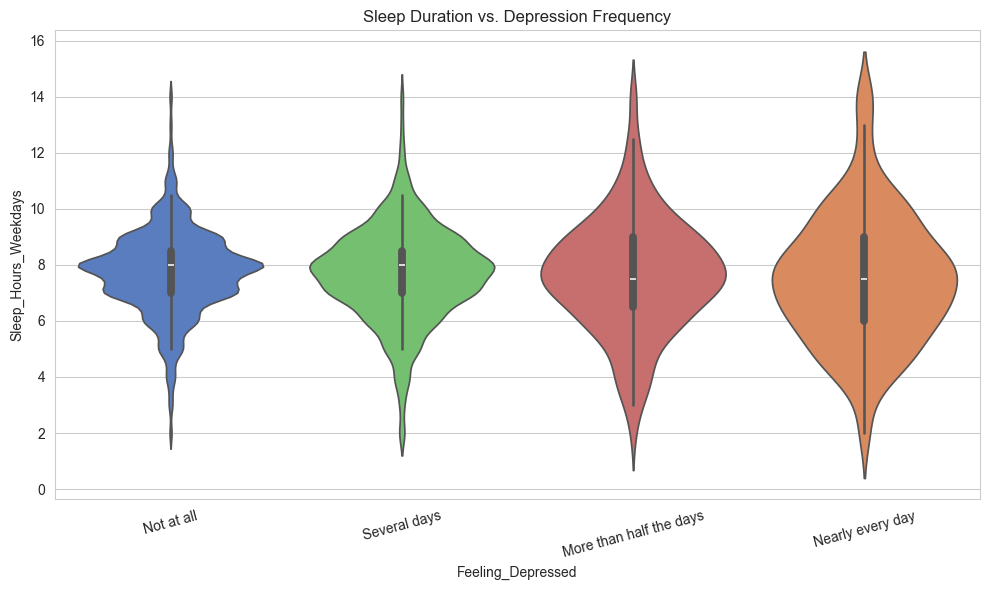

In [55]:
# F. Sleep vs Depression
if 'Avg_Sleep' in df.columns and 'Feeling_Depressed' in df.columns:
    plt.figure(figsize=(10, 6))
    order = ['Not at all', 'Several days', 'More than half the days', 'Nearly every day']
    ax = sns.violinplot(
        data=df,
        x='Feeling_Depressed',
        y='Sleep_Hours_Weekdays',
        hue='Feeling_Depressed',  
        order=order,
        palette='muted'
    )
    if ax.legend_ is not None:
        ax.legend_.remove()

    plt.title('Sleep Duration vs. Depression Frequency')
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()


# Saving to CSV

In [56]:
df.to_csv('data/data.csv', index=False)